##**Package loading**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

##**Mount to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/train"
val_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/val"
test_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/test"

##**Load the data**

In [ ]:
torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern.
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


##**Check the labels of the train dataset**

In [ ]:
# Check labels for one batch of the training data
for images, labels in train_loader:
    print("Labels for one batch:", labels)
    print("Class names for one batch:", [list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(label)] for label in labels])
    break  # Only look at the first batch


Labels for one batch: tensor([1, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 2, 0, 1, 0, 1, 0, 1, 3, 3, 0, 1, 0, 1,
        2, 0, 0, 2, 2, 3, 3, 3])
Class names for one batch: ['organics', 'trash', 'organics', 'organics', 'recycle', 'hazardous', 'recycle', 'hazardous', 'trash', 'recycle', 'hazardous', 'recycle', 'hazardous', 'organics', 'hazardous', 'organics', 'hazardous', 'organics', 'trash', 'trash', 'hazardous', 'organics', 'hazardous', 'organics', 'recycle', 'hazardous', 'hazardous', 'recycle', 'recycle', 'trash', 'trash', 'trash']


##**Check labels for the validation data**

In [ ]:
for images, labels in validation_loader:
     print("Labels for one batch:", labels)
     print("Class names for one batch:", [list(val_dataset.class_to_idx.keys())[list(val_dataset.class_to_idx.values()).index(label)] for label in labels])
     i+=1 # Only look at the first batch


Labels for one batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Class names for one batch: ['hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous']
Labels for one batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
Class names for one batch: ['hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'organics', 'organics', 

##**Buildup the arichitecture**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Categories=['trash','recycle','organics', 'hazardous']
        super(VGG16, self).__init__()
        self.name= "VGG16"
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # four classes

# Print the model architecture
print(vgg16)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

##**Set up the loss function and  Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
# For multi-class classification
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.01

#device should be defined based on system's configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

##**Train the model and get the accuray only**

In [ ]:
num_epochs = 15  # Set the number of epochs
for epoch in range(num_epochs):
    vgg16.train()  # Set the vgg16 to training mode
    total_train = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Transfer to GPU if available

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    # Calculate training accuracy
    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {train_accuracy}%')

    vgg16.eval()  # Set the vgg16 to evaluation mode
    total_val = 0
    correct_val = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Transfer to GPU if available

            outputs = vgg16(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        print(f'Validation Accuracy: {val_accuracy}%')


Epoch [1/15], Training Accuracy: 25.5%
Validation Accuracy: 25.0%
Epoch [2/15], Training Accuracy: 23.333333333333332%
Validation Accuracy: 25.0%
Epoch [3/15], Training Accuracy: 24.5%
Validation Accuracy: 25.0%
Epoch [4/15], Training Accuracy: 24.166666666666668%
Validation Accuracy: 25.0%
Epoch [5/15], Training Accuracy: 24.833333333333332%
Validation Accuracy: 25.0%
Epoch [6/15], Training Accuracy: 29.5%
Validation Accuracy: 36.0%
Epoch [7/15], Training Accuracy: 39.0%
Validation Accuracy: 38.5%
Epoch [8/15], Training Accuracy: 49.666666666666664%
Validation Accuracy: 40.0%
Epoch [9/15], Training Accuracy: 55.833333333333336%
Validation Accuracy: 52.0%
Epoch [10/15], Training Accuracy: 65.66666666666667%
Validation Accuracy: 58.0%
Epoch [11/15], Training Accuracy: 69.16666666666667%
Validation Accuracy: 52.5%
Epoch [12/15], Training Accuracy: 71.66666666666667%
Validation Accuracy: 54.5%
Epoch [13/15], Training Accuracy: 75.0%
Validation Accuracy: 58.5%
Epoch [14/15], Training Accur

##**Tuning in next stage**

In [ ]:
def train(model, train_loader, validation_loader, num_epochs, learning_rate, batch_size=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer with the learning rate parameter

    # device should be defined based on system's configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):  # Use the num_epochs parameter
        model.train()  # Set the model to training mode
        total_train = 0
        correct_train = 0
        train_preds = []
        train_targets = []
        val_preds = []
        val_targets = []
        running_loss = 0.0
        val_running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Transfer to GPU if available

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

            running_loss += loss.item() * inputs.size(0)
            loss.backward()
            optimizer.step()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        model.eval()  # Set the model to evaluation mode
        total_val = 0
        correct_val = 0
        with torch.no_grad():  # No need to track gradients for validation
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_loss = val_running_loss / len(validation_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Accuracy: {train_accuracy:.4f}, F1-Score: {train_f1:.4f}, Loss: {train_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}, Loss: {val_loss:.4f}')


In [ ]:
Originial=train(vgg16, train_loader, validation_loader, num_epochs=15, learning_rate=0.001, batch_size=32)

Epoch 1/15
Training Accuracy: 24.3333, F1-Score: 0.2244, Loss: 1.3925
Validation Accuracy: 25.0000, F1-Score: 0.1000, Loss: 1.3788
Epoch 2/15
Training Accuracy: 25.5000, F1-Score: 0.2239, Loss: 1.3697
Validation Accuracy: 27.5000, F1-Score: 0.1494, Loss: 1.3792
Epoch 3/15
Training Accuracy: 35.0000, F1-Score: 0.2721, Loss: 1.3243
Validation Accuracy: 42.0000, F1-Score: 0.3746, Loss: 1.2537
Epoch 4/15
Training Accuracy: 48.3333, F1-Score: 0.4528, Loss: 1.1654
Validation Accuracy: 49.5000, F1-Score: 0.4250, Loss: 1.1715
Epoch 5/15
Training Accuracy: 55.3333, F1-Score: 0.5126, Loss: 1.0519
Validation Accuracy: 52.0000, F1-Score: 0.4424, Loss: 1.0439
Epoch 6/15
Training Accuracy: 54.3333, F1-Score: 0.5281, Loss: 1.0105
Validation Accuracy: 57.5000, F1-Score: 0.4933, Loss: 1.0478
Epoch 7/15
Training Accuracy: 55.5000, F1-Score: 0.5326, Loss: 0.9794
Validation Accuracy: 58.5000, F1-Score: 0.5654, Loss: 0.9715
Epoch 8/15
Training Accuracy: 58.1667, F1-Score: 0.5640, Loss: 0.9637
Validation Ac

#**Confusion Matrix**

In [ ]:
# Ensure the model is in evaluation mode
vgg16.eval()

all_preds = []
all_labels = []

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        # Convert outputs probabilities to predicted class (max probability)
        _, preds = torch.max(outputs, 1)

        # Move predictions and labels to CPU and convert them to numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)


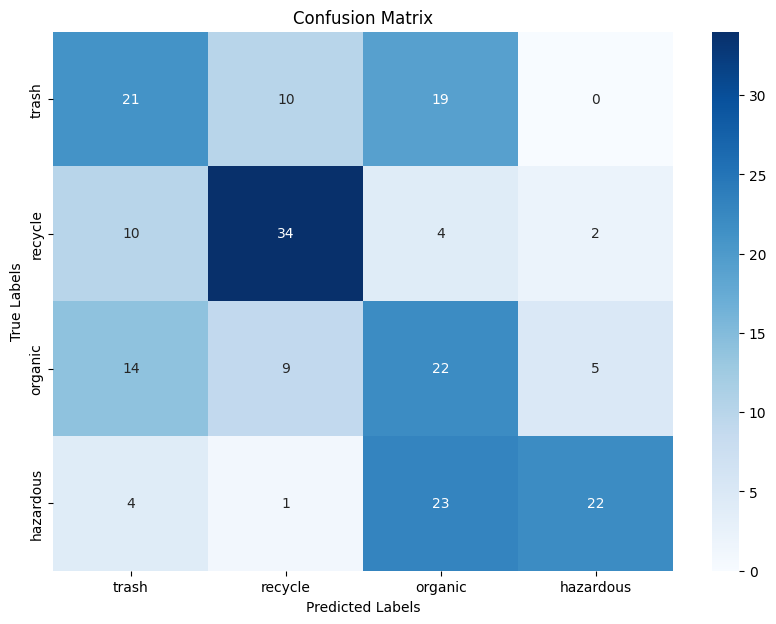

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the labels names
labels_names = ['trash','recycle','organic', 'hazardous']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels_names, yticklabels=labels_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
